In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import torch 

%load_ext autoreload
%autoreload 2

In [2]:
# For reproducibility

import random
import torch

random_seed = 44

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: %s' % device)

Device: cpu


In [4]:
step_frames = 10

GitHub

In [ ]:
! git clone "https://github.com/EnricoPittini/3d-reconstruction"

In [ ]:
%cd -0
%cd "3d-reconstruction"

Dataset processing

In [8]:
from utils.dataset_processing import unzip_dataset

# 3 minutes
unzip_dataset(zip_file_path='datasets/nyu_data.zip')


In [5]:
# TIMING INFO (only train)
# STEP FRAME 1: 8 minutes
# STEP FRAME 10: 11 sec

from utils.dataset_processing import process_trainDataset_folder
import os

source_trainDataset_folder_path = 'datasets/nyu_data/data/nyu2_train' 
traindata_path = process_trainDataset_folder(source_dataset_folder_path=source_trainDataset_folder_path, step_frames=step_frames)

Dataloaders

In [15]:
from utils.dataset_processing import CustomDataset
import os

traindata_path = f'datasets/nyu_data/data/nyu2_train/step{step_frames}' #os.path.join(os.getcwd(),source_trainDataset_folder_path,f'step{step_frames}')
testdata_path = 'datasets/nyu_data/data/nyu2_test' 

train_dataset = CustomDataset(data_path=traindata_path)
test_dataset = CustomDataset(data_path=testdata_path)
print('Training set size:', len(train_dataset))
print('Test set size:', len(test_dataset))

batch_size = 32
image_size = train_dataset[0][1].shape
print('Image size:', image_size)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2*batch_size)

Training set size: 5199
Test set size: 654
Image size: (480, 640)


torch.Size([32, 3, 480, 640])
torch.Size([32, 480, 640])


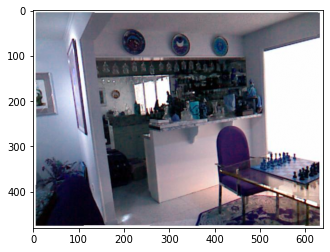

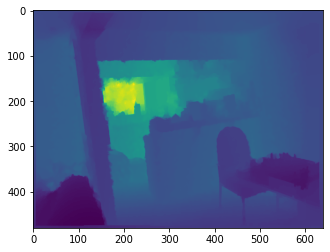

In [18]:
img_batch, target_batch = next(iter(train_dataloader))
print(img_batch.shape)
print(target_batch.shape)

plt.imshow(img_batch[0].permute((1,2,0)))
plt.figure()
plt.imshow(target_batch[0])

torch.Size([64, 3, 480, 640])
torch.Size([64, 480, 640])


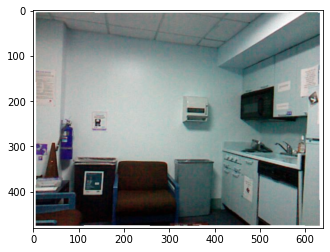

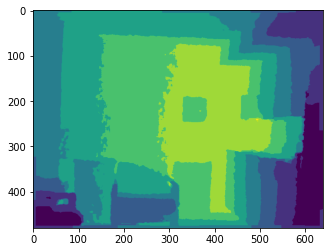

In [19]:
img_batch, target_batch = next(iter(test_dataloader))
print(img_batch.shape)
print(target_batch.shape)

plt.imshow(img_batch[0].permute((1,2,0)))
plt.figure()
plt.imshow(target_batch[0])

In [20]:
from models.huggingface_model import HuggingFaceModel
from torchsummary import summary

net = HuggingFaceModel(img_size=image_size, device=device, use_convnext=False, dim_mults=(1,2,4))

summary(net, (3, 480, 640))

torch.Size([2, 60, 480, 640])
torch.Size([2, 60, 240, 320])
torch.Size([2, 120, 120, 160])
torch.Size([2, 240, 120, 160])
torch.Size([2, 240, 120, 160])
torch.Size([2, 120, 240, 320])
torch.Size([2, 60, 480, 640])
Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 60, 480, 640]        8,880
├─ModuleList: 1                               []                        --
|    └─ModuleList: 2                          []                        --
|    |    └─ResnetBlock: 3-1                  [-1, 60, 480, 640]        65,160
|    |    └─ResnetBlock: 3-2                  [-1, 60, 480, 640]        65,160
|    |    └─Residual: 3-3                     [-1, 60, 480, 640]        31,020
|    |    └─Downsample: 3-4                   [-1, 60, 240, 320]        57,660
|    └─ModuleList: 2                          []                        --
|    |    └─ResnetBlock: 3-5                  [-1, 120, 240, 320]       202,440
|    | 

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 60, 480, 640]        8,880
├─ModuleList: 1                               []                        --
|    └─ModuleList: 2                          []                        --
|    |    └─ResnetBlock: 3-1                  [-1, 60, 480, 640]        65,160
|    |    └─ResnetBlock: 3-2                  [-1, 60, 480, 640]        65,160
|    |    └─Residual: 3-3                     [-1, 60, 480, 640]        31,020
|    |    └─Downsample: 3-4                   [-1, 60, 240, 320]        57,660
|    └─ModuleList: 2                          []                        --
|    |    └─ResnetBlock: 3-5                  [-1, 120, 240, 320]       202,440
|    |    └─ResnetBlock: 3-6                  [-1, 120, 240, 320]       259,920
|    |    └─Residual: 3-7                     [-1, 120, 240, 320]       62,040
|    |    └─Downsample: 3-8                   [-1, 120, 120, 1

In [21]:
from utils.training import train_model

from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import AdamW
from functools import partial

epochs = 100
additional_info = {'batch_size': batch_size,
                   'image_size': image_size
                  }

checkpoint_dict = train_model(net=net,
                              dataloader_train=train_dataloader,
                              dataloader_val=test_dataloader,
                              loss_function=torch.nn.MSELoss(),
                              epochs=epochs,
                              optimizer=partial(AdamW, lr=0.1),
                              scheduler=partial(OneCycleLR, max_lr=0.0005, epochs=epochs, steps_per_epoch=len(train_dataloader),
                                                pct_start =0.1),
                              device=device,
                              checkpoint_folder='checkpoints/' + f'{type(net)}'.split('.')[-1][:-2],
                              clear_previous_checkpoints=True,
                              additional_info=additional_info)

plt.plot(checkpoint_dict['loss_history'], 'o-', label='train')
plt.plot(checkpoint_dict['loss_history_val'], 'o-', label='val')
plt.yscale('log')
plt.grid()
plt.title('Log Loss curve')
plt.legend()

plt.show()

Device: cpu
No checkpoint found in checkpoints/HuggingFaceModel, using default initialization.
 
Epoch: 1/100


c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
c:\Users\pitti\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


RuntimeError: expected scalar type Double but found Float